In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data = load_boston()
data.keys()

/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing da

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

In [2]:
data["feature_names"]

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [3]:
X, y = data["data"], data["target"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#for simplicity again doing the fit_transform ealier instead of after the cross validation
pipe = Pipeline([('std_scl',StandardScaler())])
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)
# same leaking as we talked about previous in cross_validation
# remember though SVMs perform much better with scaled features

X_train = pd.DataFrame(X_train,columns=data["feature_names"])
X_test = pd.DataFrame(X_test,columns=data["feature_names"])
y_train = pd.DataFrame(y_train,columns=["target"])
y_test = pd.DataFrame(y_test,columns=["target"])

AttributeError: 'DataFrame' object has no attribute 'ravel'

In [5]:
def plotCVResults(cv_res, names):
    fig = plt.figure(figsize=(20,10))
    trainin_time_ax = fig.add_subplot(2,1,2)
    for i in range(4):
        name = names[i]
        df_reg = pd.DataFrame(cv_res[i])

        ax = fig.add_subplot(2,4,i+1)

        ax.set_title(name + " scores, adj. avg test: " + \
                     str(round(df_reg.loc[df_reg["test_score"]>0]["test_score"].mean(),2)))
        ax.set_xlabel("iteration")
        ax.set_ylabel("R2 score")
        ax.set_ylim(0,1)
        df_reg[["train_score","test_score"]].plot(ax=ax)

        df_reg["fit_time"].plot(ax=trainin_time_ax,label=name)

    plt.sca(trainin_time_ax)
    plt.legend()
    plt.show()

In [9]:
#SVR: Support Vector Regressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate

cv_res = []
kernels = ['linear','poly','rbf','sigmoid'] #for kernel selection
C = 0.1 #C: for the regularization, increasing C means decreasing regularization
for kernel in kernels:
    cv_res.append(cross_validate(SVR(kernel=kernel, #using our different kernels
                                     C=C), 
                            X_train,
                            y_train,
                            cv = 5,# we will keep it at 5, since that gives each sample set around 80 samples
                            return_train_score = True,
                            return_estimator = True,
                            n_jobs = 2))

AttributeError: 'DataFrame' object has no attribute 'ravel'

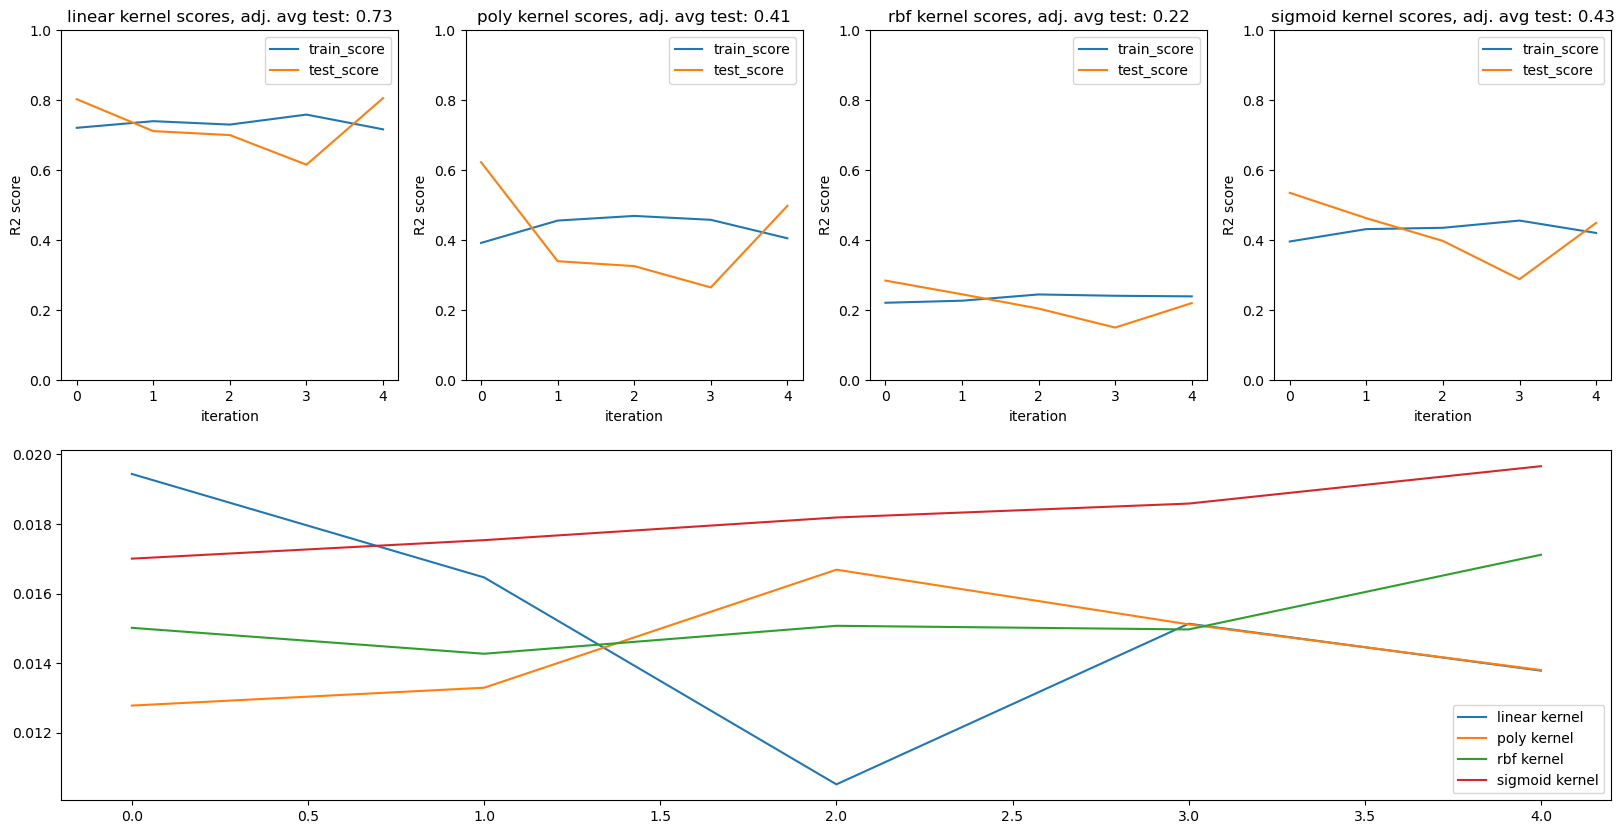

In [7]:
plotCVResults(cv_res, [str(x)+' kernel' for x in kernels])

/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


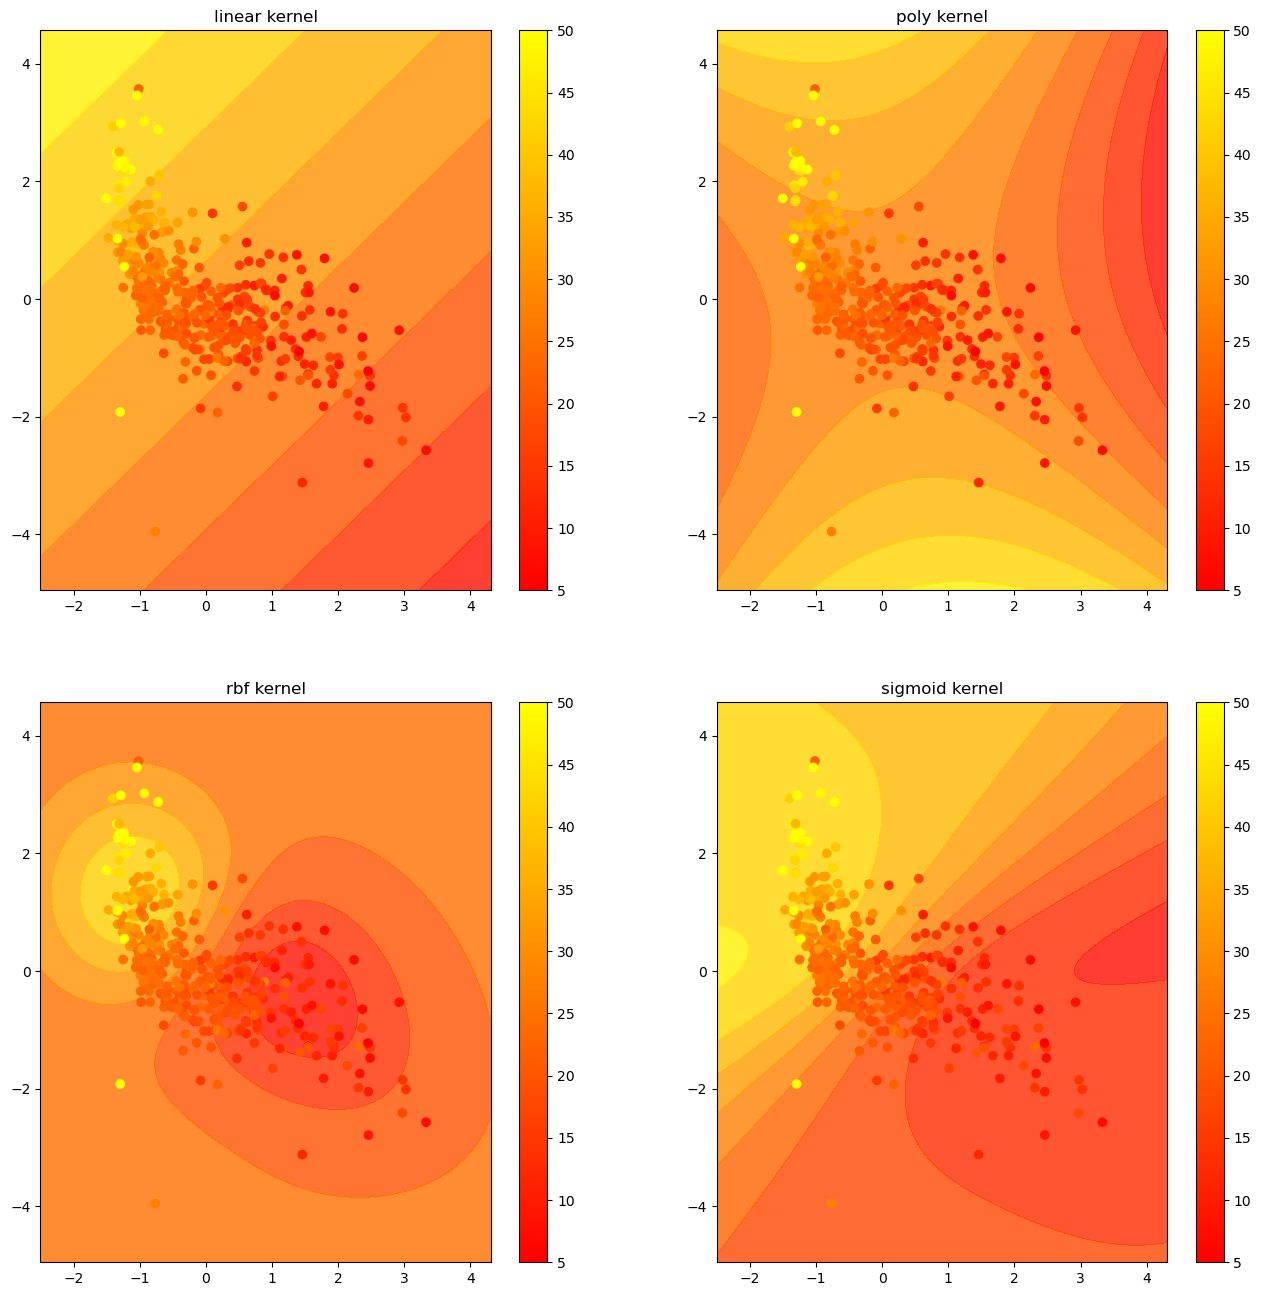

In [8]:
#how the decision boundaries look like / how predictions look like
fig = plt.figure(figsize=(16,16))
for kernel in kernels:
    ax = fig.add_subplot(2,2,kernels.index(kernel)+1)
    svm_reg = SVR(kernel=kernel,degree=2, C=C) # regularization heavily impacts the fit here 
                                               # for sigmoid especially
    svm_reg.fit(X_train[['LSTAT','RM']],y_train['target'].ravel())
    h = .02
    x_min, x_max = X_train['LSTAT'].min() - 1, X_train['LSTAT'].max() + 1
    y_min, y_max = X_train['RM'].min() - 1, X_train['RM'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    xx_r = xx.ravel()
    yy_r = yy.ravel()
    Z = svm_reg.predict(np.c_[xx_r, yy_r])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.autumn, alpha=0.8)
    plt.scatter(X_train['LSTAT'],X_train['RM'],c=y_train['target'].ravel(), cmap=plt.cm.autumn)
    plt.colorbar()
    plt.title(kernel+' kernel')
plt.show()

#results: 
#linear: shows how the steps look like
#poly: does not seem to fit the problem
#rbf: creating different gaussian distributions (one on the higher blob the other one on the lower blob)
#sigmoid: also showing the steps but more distributed

##### So of course, the support vector machines are,are generally machine learning models when you have so many features that you can't really picture all of the relations in your head anymore.I think int his case, in this dataset, we have about 13 different features.So we've got basically 13 different dimensions that our data goes over. And so it can be hard to keep all of that in, in your head. And so tuning the parameters either manually first a little bit just to see what has an effect on what and where the tunings may be more impactful than in other cases.And then doing either a full grid search or a randomize grid search depending on your sample size can be very high helpful in finding better parameters because we can see just by tuning the parameters, the shape of, well,the function that we have here has basically completely flipped in the sigmoid kernel case. So that's just an important also observation that I want you to take away from this. But yeah,the rest basically like we've seen forall other sklearn machine learning models,we just initialize it and then we put inthe hyperparameters that we're always going through in the theory and then we can just apply it in the same way. And so again, it's super convenient because all of the visualization code, for example, that we're using here.And well, also this code, if we want as long as we keep the same dimensions, we can continue to reuse this, which is very, very convenient, because of the way thatthe models are structured in the I could learn API.